<a href="https://colab.research.google.com/github/KendallScott/QTW/blob/main/Case%20Study%207/CaseStudy7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn-intelex


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearnex import patch_sklearn
#patch_sklearn()
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.utils import shuffle
from numpy import random
from itertools import product

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import DMatrix

In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
df = pd.read_csv("drive/My Drive/final_project(5).csv")

In [ ]:
df.info()
#there are NAs will need handling

In [ ]:
for i in df.columns:
    if df[i].isna().sum() > 0:
        print('{} has {}% NAs'.format(i,(df[i].isna().sum() / len(df))*100))

x0 has 0.01625% NAs
x1 has 0.015625% NAs
x2 has 0.02375% NAs
x3 has 0.023125% NAs
x4 has 0.01625% NAs
x5 has 0.023125% NAs
x6 has 0.01625% NAs
x7 has 0.016875% NAs
x8 has 0.013125% NAs
x9 has 0.01875% NAs
x10 has 0.026875% NAs
x11 has 0.01875% NAs
x12 has 0.0225% NAs
x13 has 0.019375% NAs
x14 has 0.021249999999999998% NAs
x15 has 0.021875000000000002% NAs
x16 has 0.01625% NAs
x17 has 0.016875% NAs
x18 has 0.025% NAs
x19 has 0.021875000000000002% NAs
x20 has 0.02375% NAs
x21 has 0.018125% NAs
x22 has 0.016875% NAs
x23 has 0.029375000000000002% NAs
x24 has 0.017499999999999998% NAs
x25 has 0.01375% NAs
x26 has 0.0225% NAs
x27 has 0.01875% NAs
x28 has 0.021875000000000002% NAs
x29 has 0.01875% NAs
x30 has 0.01875% NAs
x31 has 0.024374999999999997% NAs
x32 has 0.019375% NAs
x33 has 0.025625000000000002% NAs
x34 has 0.025625000000000002% NAs
x35 has 0.01875% NAs
x36 has 0.016875% NAs
x37 has 0.014374999999999999% NAs
x38 has 0.019375% NAs
x39 has 0.014374999999999999% NAs
x40 has 0.0225% NA

In [ ]:
df['x24'].value_counts()

In [ ]:
plt.bar(x=df['x24'].value_counts().index,height=df['x24'].value_counts().values)

In [ ]:
df['x29'].value_counts()

July       45569
Jun        41329
Aug        29406
May        21939
sept.      10819
Apr         6761
Oct         2407
Mar         1231
Nov          337
Feb          140
Dev           23
January        9
Name: x29, dtype: int64

In [ ]:
#clean up month formatting to standard 3 letters
df['x29'].replace(to_replace=['July','sept.','Dev','January'],value=['Jul','Sep','Dec','Jan'],inplace=True)

<BarContainer object of 12 artists>

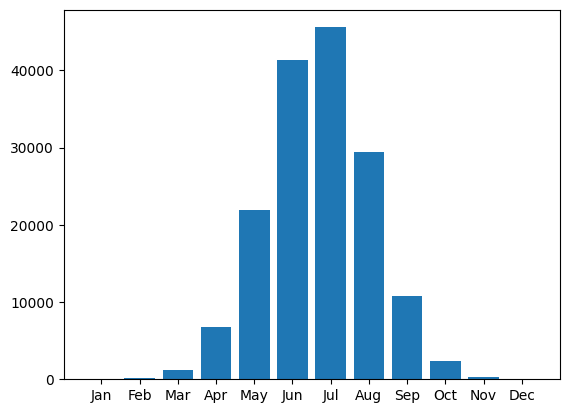

In [ ]:
mo = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
heights = []
for i in mo:
    x = df['x29'].to_list().count(i)
    heights.append(x)
plt.bar(x=mo,height=heights)

In [ ]:
df['x30'].value_counts()

wednesday    101535
thurday       29429
tuesday       27954
friday          564
monday          488
Name: x30, dtype: int64

<BarContainer object of 5 artists>

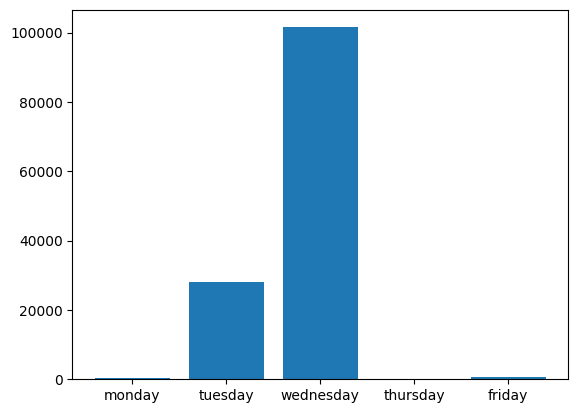

In [ ]:
# thursday is incorrect
df['x30'].replace(to_replace = 'thurday',value='thursday')
days = ['monday','tuesday','wednesday','thursday','friday']
d_heights = []
for i in days:
    x = df['x30'].to_list().count(i)
    d_heights.append(x)
plt.bar(x=days,height = d_heights)

In [ ]:
df['x32'].value_counts()

0.01%     40767
-0.01%    34094
0.0%      33923
-0.0%     30492
-0.02%     9924
0.02%      7987
-0.03%     1727
0.03%       855
-0.04%      138
0.04%        55
-0.05%        6
0.05%         1
Name: x32, dtype: int64

In [ ]:
df['x37'].value_counts()


$-311.26     6
$-336.77     6
$237.4       6
$72.42       6
$341.26      6
            ..
$-505.21     1
$770.07      1
$74.62       1
$-1082.96    1
$-1229.34    1
Name: x37, Length: 129198, dtype: int64

In [ ]:
### x32 and x37 are actually numeric with string format (even though x32 has few "levels" or possible values)
### x32 is in percentage, but don't think it needs to be transformed to proportion since data will be scaled later (will double check, but should make no difference)

df['x32'] = df['x32'].transform(lambda x: float(str(x).replace('%','')))
df['x37'] = df['x37'].transform(lambda x: float(str(x).replace('$','')))

In [ ]:
#all significanlty less than 5%, should be no issue imputing,
#imputing categorical features with modes
# imputing continent with mode, then dates by mode grouped by continent

print('imputing continent with mode: {}'.format(df['x24'].aggregate(pd.Series.mode)))
df['x24'] = df['x24'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))

print('imputing month with mode by cont: {}'.format(df[['x24','x29']].groupby(by='x24').aggregate(pd.Series.mode)))
idx_29 = df.loc[df['x29'].isna(),:].index #saving NAs indices to quick check what they've been imputed with
df['x29'] = df[['x24','x29']].groupby(by='x24').transform(lambda grp: grp.fillna(pd.Series.mode(grp)[0]))

# will fix index showing on print later


imputing continent with mode: 0    asia
Name: x24, dtype: object
imputing month with mode by cont:          x29
x24         
america  Jul
asia     Jul
euorpe   Jul


In [ ]:
df[['x24','x29','x30']].groupby(by=['x24','x29']).aggregate(pd.Series.mode)
# could just impute with wednesday since Wed is mode per month, but adding continent gives more context and different days for some months

x30
x24     x29           
america Apr  wednesday
        Aug  wednesday
        Feb    tuesday
        Jul  wednesday
        Jun  wednesday
        Mar  wednesday
        May  wednesday
        Nov  wednesday
        Oct  wednesday
        Sep  wednesday
asia    Apr  wednesday
        Aug  wednesday
        Dec  wednesday
        Feb  wednesday
        Jan  wednesday
        Jul  wednesday
        Jun  wednesday
        Mar  wednesday
        May  wednesday
        Nov  wednesday
        Oct  wednesday
        Sep  wednesday
euorpe  Apr  wednesday
        Aug  wednesday
        Dec  wednesday
        Feb    tuesday
        Jul  wednesday
        Jun  wednesday
        Mar  wednesday
        May  wednesday
        Nov  wednesday
        Oct  wednesday
        Sep  wednesday

In [ ]:
# impute day
df['x30'] = df[['x24','x29','x30']].groupby(by=['x24','x29']).transform(lambda grp: grp.fillna(pd.Series.mode(grp)[0]))

In [ ]:
X = df.loc[:,df.columns != 'y']
y = df['y'].values.flatten()

df_num = X.select_dtypes(exclude='object')
num_cols = df_num.columns

# impute numeric with median
for i in num_cols:
    df_num[i] = df_num[i].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))
df_num.info()

df_cat = X.select_dtypes(include='object')
cat_cols = df_cat.columns

# scale numerical data
scaler = StandardScaler()
df_num = scaler.fit_transform(df_num)

#one hot encode cat data
encoder = OneHotEncoder(sparse_output=False)
df_cat = encoder.fit_transform(df_cat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 47 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x0      160000 non-null  float64
 1   x1      160000 non-null  float64
 2   x2      160000 non-null  float64
 3   x3      160000 non-null  float64
 4   x4      160000 non-null  float64
 5   x5      160000 non-null  float64
 6   x6      160000 non-null  float64
 7   x7      160000 non-null  float64
 8   x8      160000 non-null  float64
 9   x9      160000 non-null  float64
 10  x10     160000 non-null  float64
 11  x11     160000 non-null  float64
 12  x12     160000 non-null  float64
 13  x13     160000 non-null  float64
 14  x14     160000 non-null  float64
 15  x15     160000 non-null  float64
 16  x16     160000 non-null  float64
 17  x17     160000 non-null  float64
 18  x18     160000 non-null  float64
 19  x19     160000 non-null  float64
 20  x20     160000 non-null  float64
 21  x21     16

In [ ]:
X = np.hstack([df_num,df_cat])

In [ ]:
df['y'].value_counts() # not balanced

0    95803
1    64197
Name: y, dtype: int64

In [ ]:
#add y plot

In [ ]:
skf = StratifiedKFold(n_splits=5,random_state=807,shuffle=True)
skf.get_n_splits(X,y)

5

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(random_state=624,n_jobs=-1,n_estimators=50,criterion='gini', class_weight='balanced')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
from numpy import random
from itertools import product
from sklearn.utils import shuffle

In [ ]:
#setting up a hyperparameter dataframe

learning_rates = [0.15, 0.25, 0.35]
max_depths = [3, 5, 10, 20]
gamma = [0,1,3]
lambda_ls = [1,2,3]
alpha = [0,0.1,1]

xgb_param = pd.DataFrame(list(product(learning_rates, max_depths, gamma, lambda_ls, alpha)), columns=['learning_rate', 'max_depth', 'gamma', 'lambda', 'alpha'])

#randomizing the dataframe order
xgb_param = shuffle(xgb_param)
xgb_param = xgb_param.reset_index()
xgb_param=xgb_param.drop(['index'], axis=1)
xgb_param

,learning_rate,max_depth,gamma,lambda,alpha
0,0.25,10,0,1,0.0
1,0.10,20,0,1,0.1
2,0.10,5,1,3,1.0
3,0.10,3,3,1,0.1
4,0.10,20,3,3,0.0
...,...,...,...,...,...
211,0.25,3,0,1,0.1
212,0.25,3,0,2,1.0
213,0.10,3,0,3,0.0
214,0.10,10,1,2,1.0


In [ ]:
dtrain = xgb.DMatrix(X, label=y, enable_categorical=True)

trials = 20
best_params = {}
i=0

for i in range(trials):
  #random sampling from paramdf
  hyperparams = {'objective': 'binary:logistic', 'eta': xgb_param['learning_rate'][i], 'max_depth': xgb_param['max_depth'][i], 'gamma': xgb_param['gamma'][i], 'lambda': xgb_param['lambda'][i], 'alpha': xgb_param['alpha'][i]}

  print(hyperparams)
  out=xgb.cv(params=hyperparams,  num_boost_round=50, dtrain=dtrain, nfold=5, stratified=True, early_stopping_rounds=5, verbose_eval=1)
  index=out.shape[0]-1
  result=out.iloc[index,2]
  if i< 1:
    best_result = result
    best_params = hyperparams

  if result< best_result:
      best_result = result
      best_params = hyperparams
      print('result: ' ,result)
      print('best result: ' ,best_result)
      print('hyperparameters: ' ,hyperparams)
      print('best hyperparameters: ' ,best_params)
      i+=1

In [ ]:
best_params

In [ ]:
hyperparams = { 'eta':0.1, 'max_depth': 20, 'gamma': 3, 'lambda': 3, 'alpha': 1.0, 'objective': 'binary:logistic'}

XGBModel = xgb.XGBClassifier(params=hyperparams, num_boost_round=200, dtrain=dtrain, nfold=5, stratified=True, early_stopping_rounds=5, verbose_eval=1)

In [ ]:
skf_results = skf(XGBModel,X,y,scoring = ['roc_auc','accuracy','precision','recall'])
skf_results

In [ ]:
#setting up a hyperparameter dataframe for RF
min_samples_leaf = [3,4,5]
max_features = ['sqrt',7,10,'log2',None]
min_samples_split = [2,4,8]

rf_param = pd.DataFrame(list(product(min_samples_leaf, max_features, min_samples_split)), columns=['min_samples_leaf', 'max_features', 'min_samples_split'])

#randomizing the dataframe order
rf_param = shuffle(rf_param)
rf_param = rf_param.reset_index()
rf_param=rf_param.drop(['index'], axis=1)
rf_param

In [ ]:
trials = 20
best_params = {}
i=0

for i in range(trials):
  #random sampling from paramdf

  hyperparams = {'objective': 'binary:logistic', 'min_samples_leaf': rf_param['min_samples_leaf'][i], 'max_features': rf_param['max_features'][i], 'min_samples_split': rf_param['min_samples_split'][i]}
  print(hyperparams)

  rf = RandomForestClassifier(random_state=624,n_jobs=-1,n_estimators=50,criterion='entropy', class_weight='balanced')
  outrf=rf.cv(params=hyperparams, nfold=5, stratified=True)

  index=out.shape[0]-1
  result=outrf.iloc[index,2]
  if i< 1:
    best_result = result
    rf_best_params = hyperparams

  if result< best_result:
      best_result = result
      rf_best_params = hyperparams
      print('result: ' ,result)
      print('best result: ' ,best_result)
      print('hyperparameters: ' ,hyperparams)
      print('best hyperparameters: ' ,rf_best_params)

      i+=1